### Import dataset

In [1]:
data <- read.csv("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/_m/features_data.csv")
head(data)

Animal,Corte,Grupo,Region,Foreground.pixels.by.hull.area,Hull.Area,Diameter.of.Bounding.Circle,Mean.Radius,Cell.Area,Cell.Perimeter,...,Hull.void.area,Branches,Junctions,End.point.voxels,Triple.points,Quadruple.points,Average.branch.length,Maximum.branch.length,D,Lacunarity
CS2,1,CS,CA1,0.5968,2282,74.9667,31.5814,1362,344.416,...,920,15,7,9,7,0,13.283,29.556,1140,801
CS2,1,CS,CA1,0.8191,376,32.8571,14.7844,308,91.983,...,68,3,1,3,1,0,13.876,22.142,41,1246
CS2,1,CS,CA1,0.4057,2036,78.4092,32.8051,826,246.635,...,1210,7,3,5,3,0,17.840,34.627,87,1271
CS2,1,CS,CA1,0.4576,2380,69.3097,30.9999,1089,341.061,...,1291,20,11,7,11,0,10.674,27.385,429,1659
CS2,1,CS,CA1,0.4241,2457,70.9627,32.7330,1042,371.588,...,1415,18,9,9,9,0,12.222,20.071,585,1452
CS2,1,CS,CA1,0.2993,5362,119.4364,50.7948,1605,709.720,...,3757,40,19,20,17,1,10.588,31.799,538,1596


## Clustering with optimun configuration

k = 3
Circularity
Endpoints
Hull Area
Cell Perimeter

In [2]:
suppressPackageStartupMessages(library(tidyverse))

# filter data
id.data       <- data[,1:4]
filtered.data <- data %>% select(Circularity,End.point.voxels,Hull.Area,Cell.Perimeter)

# pca
pca.data <- prcomp(filtered.data, center = TRUE, scale = TRUE)
pca.x    <- pca.data$x[,1:2]

# clustering
clust.data <- hclust(dist(pca.x,method = "euclidian"), method = "ward.D2")
clust.id   <- as.factor(cutree(clust.data,k=3))

#### Dendrogram

Warning message in `labels<-.dendrogram`(dend, value = value, ...):
“The lengths of the new labels is shorter than the number of leaves in the dendrogram - labels are recycled.”Warning message in rep(new_labels, length.out = leaves_length):
“'x' is NULL so the result will be NULL”

integer(0)

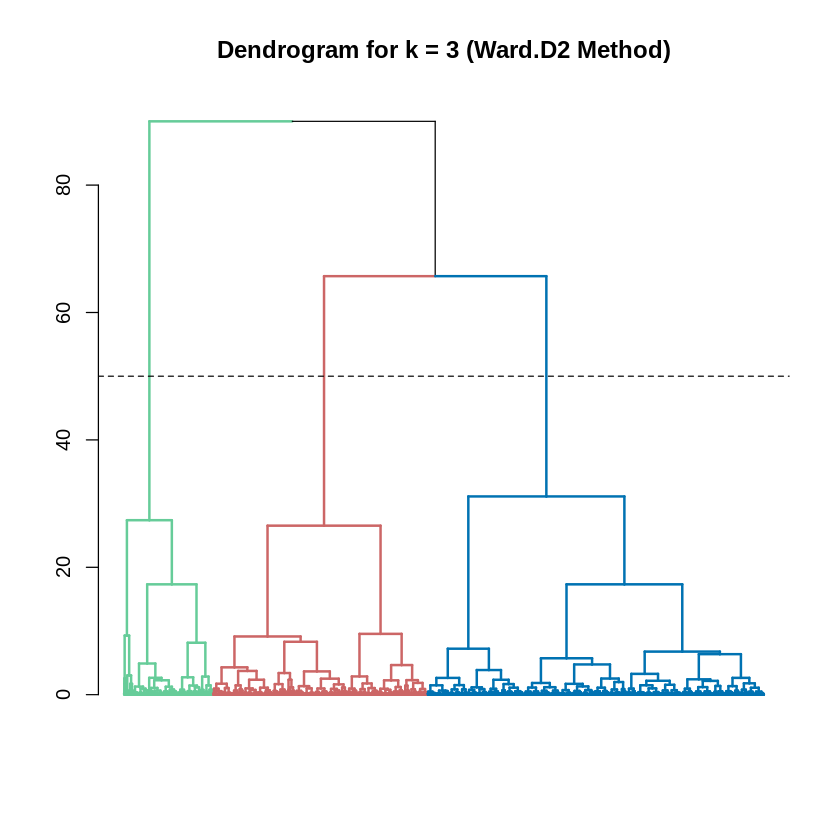

In [3]:
suppressPackageStartupMessages(library(dendextend))

colbranches <- function(n, col){
  a <- attributes(n) # Find the attributes of current node
  # Color edges with requested color
  attr(n, "edgePar") <- c(a$edgePar, list(col=col, lwd=2))
  n # Don't forget to return the node!
  }

title <- "Dendrogram for k = 3 (Ward.D2 Method)"

dend <- clust.data %>%  
  as.dendrogram() %>% set("labels", NULL)

dend[[1]] = dendrapply(dend[[1]], colbranches, "#66CC99")
dend[[2]][[1]] = dendrapply(dend[[2]][[1]], colbranches, "#CC6666")
dend[[2]][[2]] = dendrapply(dend[[2]][[2]], colbranches, "#0072B2")

#plot(dend, main = title)
plot(dend, main = title, type = "rectangle") + abline(h = 50, lty = 2)

rm(title)

#### PCA

In [4]:
# had some problems installing the package so did in this way
source("ggbiplot.R")

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:purrr’:

    compact


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



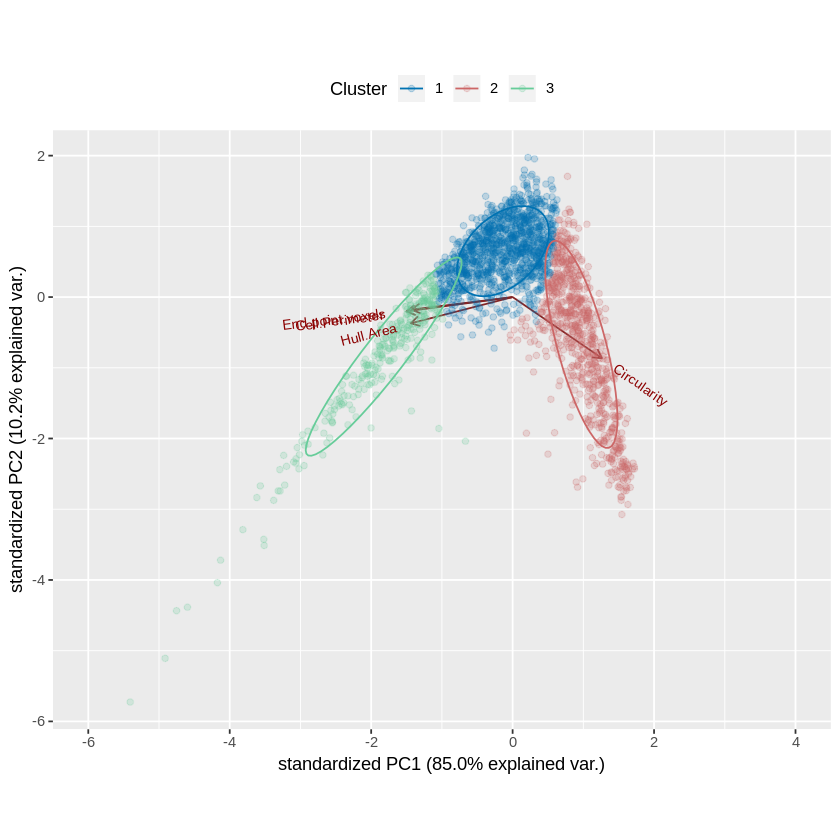

In [5]:
ggbiplot(pca.data, choices = 1:2, alpha = 0.2, ellipse = TRUE, 
groups = clust.id) + scale_color_manual(name="Cluster", 
values=c("#0072B2","#CC6666","#66CC99")) +
theme(legend.direction ="horizontal", legend.position = "top") +
xlim(c(-6,4))

### Filtrar células
Filtrar células que não são do hipocampo!

#### Filter function

In [6]:
get.cell.index <- function(animal,slice,id,data, region = "CA3"){
  if(length(id) == 1){
  # first cell from that slice <- min(which(animal,slice))
  first.cell <- min(which(data[,1] == animal &
                          data[,2] == slice &
                          data[,4] == region))
  # index <- first cell from that slice + (id - 1)
  index <- first.cell + (id -1)
  return(index)
  }
  else{
    index <- c(rep(0,length(id))) # initialize index vector
    for(i in 1:length(id)){
        first.cell <- min(which(as.character(data[,1]) == as.character(animal[i]) &
                                data[,2] == slice[i] &
                                data[,4] == region))
        index[i] <- first.cell + (id[i] -1)
    }
    return(index)
  }
}




Filter cells...

In [7]:
# Cells to filter
AL <- data.frame(animal = c(rep("AL1", 7),rep("AL2",10),rep("AL4",4)),
                  slice = c(rep(3,14),rep(4,3),rep(3,4)),
                   cell = c(c(3,5,6,9,12,14,15),
                            c(4,5,7,8,9,11,14),
                            c(6,7,15),
                            c(5,6,7,8)))

AS <- data.frame(animal = c(rep("AS3", 3),rep("AS3",2)),
                  slice = c(rep(3,3),rep(4,2)),
                   cell = c(c(7,8,9),
                            c(1,2)))

CS <- data.frame(animal = c(rep("CS2", 12),rep("CS4",2),rep("CS5",2)),
                  slice = c(rep(3,12),rep(4,2),rep(3,2)),
                   cell = c(c(3,4,5,7,8,9,10,11,12,13,14,15),
                            c(6,11),
                            c(9,12)))

# Index of cells to filter
cells.to.filter <- c(get.cell.index(AL$animal,AL$slice,AL$cell,data),
                     get.cell.index(AS$animal,AS$slice,AS$cell,data),
                     get.cell.index(CS$animal,CS$slice,CS$cell,data))

hippo.data <- filtered.data[-cells.to.filter,]

rm(CS,AS,AL)

a

a